# DSCI 100 Final Group Project Report: Joanne, Jaslyne, Maisha & William 
## Can the start time predict the playing session length in sessions.csv?

## **Introduction**

Plaicraft is a project run by PLAI which is the **Pacific Laboratory for Artificial intelligence** which was founded in 2018 by prof. Frank Woods. This project is based in the UBC computer science department and is used to collect data which is used in the research and development of Artificial Intelligence (Pacific Laboratory for Artificial Intelligence, n.d). To collect this data, the researchers used a free version of the video game Minecraft in the cloud and allowed individuals to play in order to collect player data. This data is then used to train and develop AQI agents also known as Artificial General Intelligence to be used in NPCs or Non Player Characters in video games. By training AQI Agents from player data, they will be able to produce more intelligent NPCs which could improve gameplay (Pacific Laboratory for Artificial Intelligence, 2024). Through the data collected in Plaicraft, they were able to produce two datasets called players.csv and sessions.csv. Players.csv includes player information such as names, emails, self reported skill level, age, gender, played hours and if they subscribed or not to the project. Sessions.csv includes emails, start times and end times for player sessions. 

After examining the datasets, our group asked the question: **can the start time of a session predict how long a player spends on the game?**. By doing this research, we hope to find out more about patterns in player counts and what could be causing fluctuations in player activity. By knowing this information, we should be able to optimize in-game events such as server updates and maintenance, better manage traffic loads and increase player engagement. For this project we used the **sessions.csv** dataset, as it provides information about the playing session times, which we can use to answer our question.

## **Method & Results**

### Methods
- **Method**: Use KNN regression to build a model that predicts the session time in minutes when given the start time 
- KNN regression predicts a quantitative variable by finding the k-nearest neighbours in terms of predictors and averages the values, using them to predict the session time
    - a **five-fold cross-validation** will be used to determine the k value (number of neighbors to be used in the regression model) to get a better estimate of performance
      

### Loading Libraries

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
library(lubridate)
library(hms)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

### Loading Data

Loading the data in using the **read_csv** function and the link to the datasets on a public GitHub repository.

In [2]:
session_data <- read_csv("https://raw.githubusercontent.com/jaslynemarek/DSCI-Project-Individual/refs/heads/main/sessions.csv")
head(session_data)

Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


### Data Wrangling

The **mutate** function is used to:
- change the start and end times from <chr> to <dttm>
- add a new column called **session_time**, which is the end time - start time for a particular observation, and turn it into a numerical value
- add a new column called **start_time_hms**, which just represents the start time in hours, minutes and seconds
- add a new column called **start_time_numeric**, representing the start time in seconds since midnight, so that a numerical value can be used in the regression model

The **select** function is used to:
- remove the original start time and original end time functions as they are not relevant to our data analysis

**Note**: we assumed that the time zone being used for these observations is Pacific Standard time.

In [19]:
session_data_mutated <- session_data |>
                    mutate(
                            start_time = dmy_hm(start_time),
                            end_time = dmy_hm(end_time),
                            session_time = end_time - start_time,
                            start_time_hms = as_hms(start_time),
                            session_time = as.numeric(session_time),
                            start_time_numeric = as.numeric(start_time_hms)) |>
                    select(-original_start_time, -original_end_time)
             
head(session_data_mutated)

hashedEmail,start_time,end_time,session_time,start_time_hms,start_time_numeric
<chr>,<dttm>,<dttm>,<dbl>,<time>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-30 18:12:00,2024-06-30 18:24:00,12,18:12:00,65520
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-06-17 23:33:00,2024-06-17 23:46:00,13,23:33:00,84780
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,2024-07-25 17:34:00,2024-07-25 17:57:00,23,17:34:00,63240
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-07-25 03:22:00,2024-07-25 03:58:00,36,03:22:00,12120
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,2024-05-25 16:01:00,2024-05-25 16:12:00,11,16:01:00,57660
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,2024-06-23 15:08:00,2024-06-23 17:10:00,122,15:08:00,54480


### Dataset Summary

**About sessions.csv:**
- features variables such as the player's email, start and end time, and has been wrangled to include the session time in minutes, the start time in hours, and the numeric start time in seconds since midnight to make regression easier
- has 1535 observations, each representing a playing session

Summary Statistics:
| Mean Session Length (minutes) | Minimum Session Length (minutes) | Maximum Session Length (minutes) |
|:-------------------:|:----------------------:|:----------------------:|
|50.85|3|259|


In [4]:
session_time_statistics <- summarize(session_data_mutated, mean_session_time = mean(session_time, na.rm = TRUE),
                                    min_session_time = min(session_time, na.rm = TRUE),
                                    max_session_time = max(session_time, na.rm = TRUE))
session_time_statistics


mean_session_time,min_session_time,max_session_time
<dbl>,<dbl>,<dbl>
50.85845,3,259


### Visualization

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


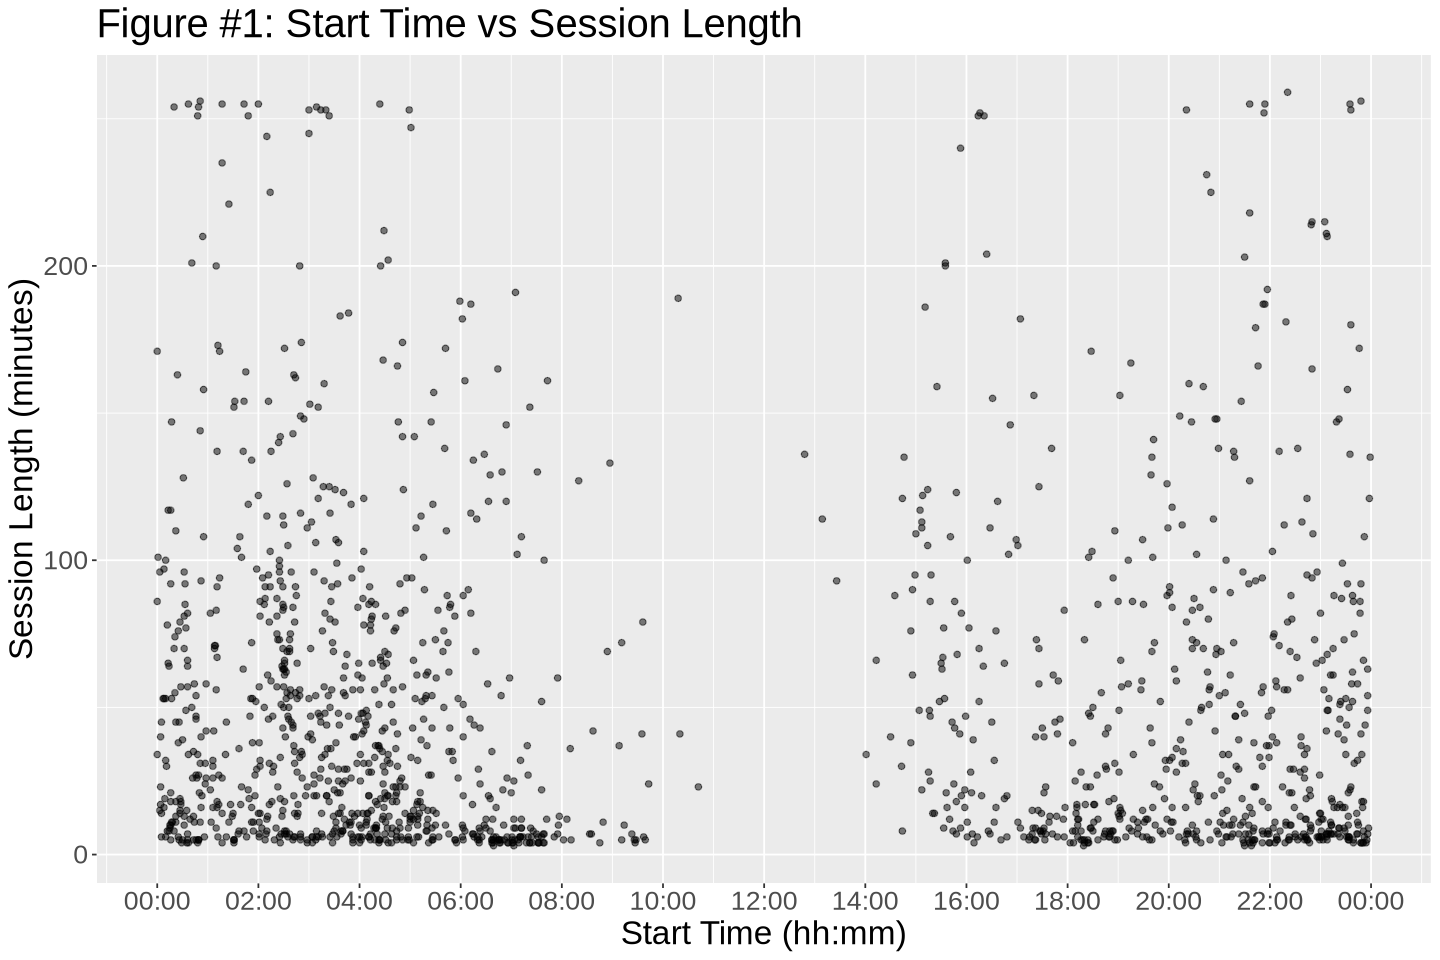

In [23]:
options(repr.plot.width = 12, repr.plot.height = 8)
time_plot <- ggplot(session_data_mutated, aes(x = start_time_hms, y = session_time))+
            geom_point(alpha = 0.5)+
            xlab("Start Time (hh:mm)")+
            ylab("Session Length (minutes)")+
            ggtitle("Figure #1: Start Time vs Session Length")+
            theme(text = element_text(size = 20))+
            scale_x_time(breaks = seq(0,24*3600, by = 2*3600), labels = scales::time_format("%H:%M"))
time_plot

Very few players are starting their sessions between 08:00 and 14:00, server is busy otherwise.

- **Figure 1** does not show a linear pattern, which is why linear regression is **not** going to be used for this model. A KNN regression makes more sense based on the above visualization which depicts the start time on the x-axis, and the session length on the y-axis.

### Data Analysis

First we begin with splitting the data into different sets of training and testing so that we can build our model, and then test it using unseen data. The proportion of this split is 75% to 25%, with 75% of the data going towards the training: building the model, and 25% to testing: evaluating how well the regression model works.

In [6]:
session_split <- initial_split(session_data_mutated, prop = 0.75, strata = session_time)
session_train <- training(session_split)
session_test <- testing(session_split)

Below, a recipe is created for preprocessing data, with the numeric start time being used as a predictor variable, and scaling/centering the predictors.

Then the model is built using the **nearest_neighbor()** function, and setting engine to kknn and mode to regression. We are setting the neighbours to tune(), so that we can determine the k-value with the lowest root mean square prediction error (RMSPE).

A five fold cross validation object is then prepared and the recipe and model are combined in a workflow.

In [7]:
minecraft_recipe <- recipe(session_time ~ start_time_numeric, data = session_train) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors())

minecraft_spec <- nearest_neighbor(weight_func = "rectangular",
                                                   neighbors = tune())|>
                set_engine("kknn")|>
                set_mode("regression")

minecraft_vfold <- vfold_cv(session_train, v = 5, strata = session_time)

minecraft_workflow <- workflow() |>
                        add_recipe(minecraft_recipe)|>
                        add_model(minecraft_spec)
minecraft_workflow

══ Workflow ════════════════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────
K-Nearest Neighbor Model Specification (regression)

Main Arguments:
  neighbors = tune()
  weight_func = rectangular

Computational engine: kknn 


Now the cross validation is run on a sequence of numbers from 1 to 300 by 2, which will then determine the RMSPE for each k-value in the sequence. The table below shows us these values under the **mean** column. The visualization below shows how the RMSPE changes with the number of neighbours.

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,rmse,standard,74.12454,5,1.909818,Preprocessor1_Model001
3,rmse,standard,62.12400,5,1.351065,Preprocessor1_Model002
5,rmse,standard,59.48948,5,1.154813,Preprocessor1_Model003
7,rmse,standard,58.12681,5,1.382355,Preprocessor1_Model004
9,rmse,standard,57.31073,5,1.202521,Preprocessor1_Model005
11,rmse,standard,57.20885,5,1.112333,Preprocessor1_Model006


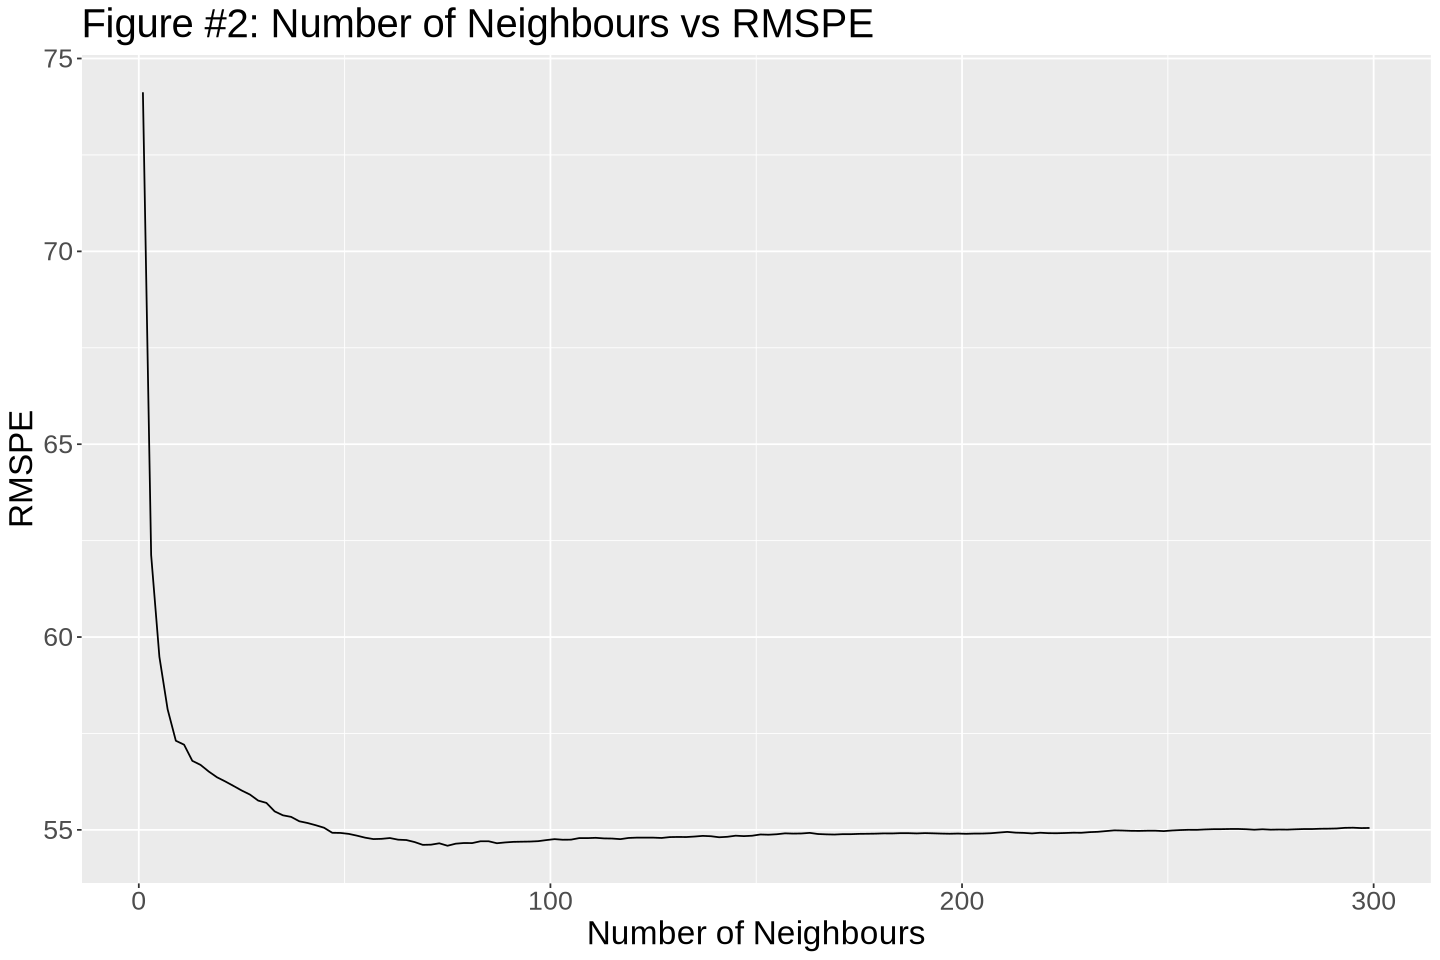

In [25]:
gridvals <- tibble(neighbors = seq(from = 1, to = 300, by = 2))

sessions_results <- minecraft_workflow |>
                tune_grid(resamples = minecraft_vfold, grid = gridvals)|>
                collect_metrics()|>
                filter(.metric == "rmse")

rmspe_graph <- ggplot(sessions_results, aes(x = neighbors, y = mean))+
                geom_line()+
                xlab("Number of Neighbours")+
                ylab("RMSPE")+
                ggtitle("Figure #2: Number of Neighbours vs RMSPE")+
                theme(text = element_text(size = 20))


head(sessions_results)
rmspe_graph

Now the **minimum** RMSPE value is pulled from the results, giving us the number of neighbours to use for the model. In this case, 75 neighbours produced the lowest RMSPE.

In [9]:
sessions_min <- sessions_results |>
            filter(mean == min(mean))
sessions_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
75,rmse,standard,54.58861,5,1.447848,Preprocessor1_Model038


Now the model will be used to evaluate the test set and see what the RMSPE is. This is done by using the whole training set and 75 neighbours (as decided previously doing the cross validation) for the regression model. 

A similar approach is used, putting the recipe and model into a workflow, and then using the model to predict the session length, using the **metrics** function to return the model's RMSPE value.

In [10]:
kmin <- sessions_min |> pull(neighbors)

sessions_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = kmin) |>
                set_engine("kknn") |>
                set_mode("regression")

sessions_fit <- workflow()|>
                add_recipe(minecraft_recipe) |>
                add_model(sessions_spec) |>
                fit(data = session_train)

sessions_summary <- sessions_fit |>
                    predict(session_test) |>
                    bind_cols(session_test) |>
                    metrics(truth = session_time, estimate = .pred)|>
                    filter(.metric == 'rmse')
sessions_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,55.53341


From this we can see that the model's error represented by RMSPE is 55.53341 minutes, similar to the 54.58861 minute RMSPE from the cross validation estimate using the tuned model. This shows that the model is applicable to the new data that it has never seen before which is good, however it means that the predicted session length error is about **55.5 minutes**.

Finally, a visualization of the regression model's predictions is below, with the predicted values for session length being represented by the blue line, and the data points are the grey dots in the background.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


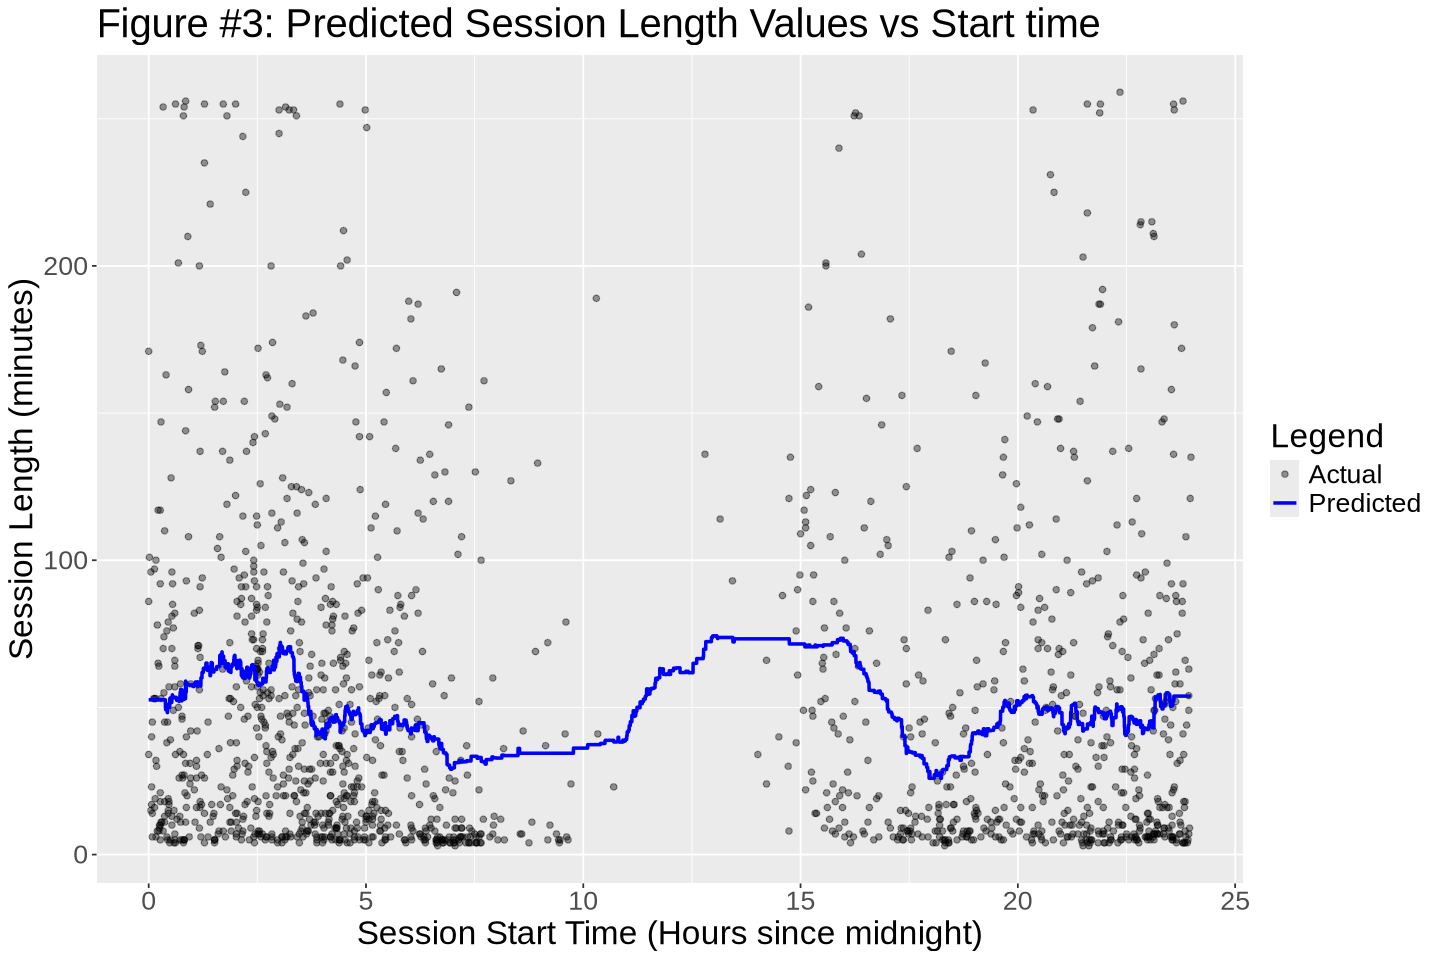

In [35]:
minecraft_prediction_grid <- tibble(start_time_numeric = seq(
                                from = min(pull(session_data_mutated, start_time_numeric)),
                                to = max(pull(session_data_mutated, start_time_numeric)),
                                by = 10))

session_preds <- sessions_fit |>
                    predict(minecraft_prediction_grid)|>
                    bind_cols(minecraft_prediction_grid)

plot_final <- ggplot(session_data_mutated, aes( x = start_time_numeric/3600, y = session_time))+
                geom_point(alpha = 0.4, aes(color = "Actual"))+
                geom_line(data = session_preds,
                          mapping = aes( x = start_time_numeric/3600, y = .pred, color = "Predicted"),
                          linewidth = 1)+
                scale_color_manual(name = "Legend", values = c("Actual" = "black", "Predicted" = "blue"))+
                xlab("Session Start Time (Hours since midnight)")+
                ylab("Session Length (minutes)")+
                ggtitle("Figure #3: Predicted Session Length Values vs Start time")+
                theme(text = element_text(size = 20))
plot_final

The predicted values fluctuate throughout the day, as seen by the blue line.

## **Discussion**

**Summary of Findings**:
The data reveals patterns in Minecraft gaming sessions:

- Lower session start frequency during daytime (7:30 AM to 3:00 PM), likely due to school or work commitments.
- Peak gaming durations observed in two key windows: between 4-5 hours and 16-17 hours after midnight, suggesting prime gaming times for night owls and late afternoon players.
- Shorter sessions occurring around 10-11 hours and 20-21 hours after midnight, possibly indicating quick gaming breaks or fatigue-related drop-offs.

|RMSPE K = 75|Mean Session Length (minutes)|
|:----------:|:---------------------------:|
|55.53|50.86|

- The **RMSPE** value of **55.53 minutes** from the testing set is quite significant, given the mean session time of **50.86 minutes**. This means that the predictions may not be very accurate considering the goal of predicting a numerical value for the playing session length.
  - The large variability between the data points in the dataset may have influenced this, as there are a large number of observations including short and longer session times.
  - This was somewhat predictable considering figure #1 and the lack of a conclusive pattern in the dataset.
  - In the future, using additional variables or exploring the session length for a specific subset of individuals may lead to a knn-regression model that may be able to better predict the playing session length.
  
Overall, due to the RMSPE value being **larger** than the mean session length, the predictions from this model are considerably inaccurate, showing that session start time may not be the most helpful variable to use when predicting the length of the playing session.
  
**Impact of These Findings**
- Game developers could optimize in-game events or updates around peak gaming hours, enhancing player engagement.
- Server administrators might adjust resources to accommodate higher traffic loads during peak hours.
- Parental guidance and education on gaming habits could use this data to encourage responsible screen time.

**Future Questions That Could Arise**
- What external factors (e.g., school schedules, work shifts, or regional culture) influence session duration? (picking exact timing) 
- Are social interactions (multiplayer vs. solo) playing a role in session length?
- How do weekends compare to weekdays in terms of gameplay trends?
- Could personalized gaming recommendations improve engagement based on individual playtime patterns?
- How does player experience play a role in start time and session length?
- Are there other variables that could have a more distinct relationship/pattern with session length?


## **References**

Pacific Laboratory for Artificial Intelligence (PLAI) Research Group (n.d). Home. https://plai.cs.ubc.ca/ 

Pacific Laboratory for Artificial Intelligence (PLAI) Research Group (2024). PLAIcraft. https://plaicraft.ai/ 